# Convolutional Neural Network for classification of CIFAR 10

## Import Modules

some notes taken from [here](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)

In [1]:
import numpy as np
np.random.seed(0)

from numpy.random import randint, random, choice

from keras.models import Sequential

from keras.layers import Conv2D, MaxPooling2D, SpatialDropout2D
from keras.layers import Flatten, Dense, Dropout, Activation

from keras.callbacks import CSVLogger

from keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical, Progbar

from keras.optimizers import Adagrad, SGD, Adam

## Load Data

In [2]:
from keras.datasets import cifar10

## Preprocess Data

[here](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) you can look into ImageDataGenerator class as a way to generate more data for the model to train on

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
X_train /= 255
X_test /= 255


Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)

## Define Model Architecture

We are going to attempt a form of [Hyperparameter Optimisation](https://en.wikipedia.org/wiki/Hyperparameter_optimization), specifically by Evolutionary Optimisation.

In [17]:
default_params = [32, 32, 0.25, 64, 64, 0.25, 128, 128, 0.25, 128, 0.9]
hyperparams = default_params[:]

# Need to generate first iteration of hyper params
models_per_iter = 100
total_iter = 100
iter_epochs = 10
mut_prob = 0.1
min_mut_prob = 1e-3
mut_decay_rate = 0.99
num_data_samples = 200
cur_model_params = [[230, 256, 0.5867159955773108, 197, 104, 0.6994386884226651, 124, 104, 0.16212026070883323, 107, 0.7392635793983017]]
t = len(cur_model_params)
for i in range(models_per_iter-t):
    params = [randint(1,128 + 1),
              randint(1,128 + 1),
              random(),
              randint(1,128 + 1),
              randint(1,128 + 1),
              random(),
              randint(1,128 + 1),
              randint(1,128 + 1),
              random(),
              randint(1,128 + 1),
              random()]
    cur_model_params.append(params)


try:
    # now to run evolutionary algorithm, we'll make the fitness function test accuracy
    for cur_iter in range(total_iter):
        print("Iteration {}".format(cur_iter + 1))
        fitness = np.zeros(models_per_iter)
        print("Calculating Fitness")
        fit_prog = Progbar(models_per_iter)
        for i in range(models_per_iter):
            params = cur_model_params[i]
            model = Sequential()

            model.add(Conv2D(params[0], (3,3), activation = 'relu', padding='same', input_shape=(32, 32, 3)))
            model.add(Conv2D(params[1], (3,3), activation = 'relu', padding='same'))
            model.add(MaxPooling2D(pool_size=(2,2)))
            model.add(SpatialDropout2D(params[2]))
            model.add(Conv2D(params[3], (3,3), activation = 'relu', padding='same'))
            model.add(Conv2D(params[4], (3,3), activation = 'relu', padding='same'))
            model.add(MaxPooling2D(pool_size=(2,2)))
            model.add(SpatialDropout2D(params[5]))
            model.add(Conv2D(params[6], (3,3), activation = 'relu', padding='same'))
            model.add(Conv2D(params[7], (3,3), activation = 'relu', padding='same'))
            model.add(MaxPooling2D(pool_size=(2,2)))
            model.add(SpatialDropout2D(params[8]))
            model.add(Flatten())
            model.add(Dense(params[9], activation='relu'))
            model.add(Dropout(params[10]))
            model.add(Dense(10, activation='softmax'))

            model.compile(loss='categorical_crossentropy',
                          optimizer=Adam(epsilon=0.1),
                          metrics=['accuracy'])

            model.fit(X_train[0:num_data_samples], Y_train[0:num_data_samples], batch_size=64,
                      epochs=iter_epochs, verbose=0)

            _, acc = model.evaluate(X_test, Y_test, verbose=0)
            
            del model

            fitness[i] = 3**(10*acc-1)

            fit_prog.add(1)

        if (cur_iter < total_iter - 1):
            print("Evolving")
            evolve_prog = Progbar(models_per_iter)
            # now to do the evolutionary part
            temp_model_params = []
            ind_argmax = np.argmax(fitness)
            if type(ind_argmax) in [np.int64, int]:
                ind_argmax = [ind_argmax]
            for ind in ind_argmax:
                temp_model_params.append(cur_model_params[np.argmax(fitness)])
                evolve_prog.add(1)
            for i in range(models_per_iter-len(ind_argmax)):
                # first select 2 parents
                indices = choice(np.arange(models_per_iter), size = 2, p=fitness/np.sum(fitness), replace=True)
                p1 = cur_model_params[indices[0]]
                p2 = cur_model_params[indices[1]]
                temp_num = randint(0, 3)
                temp_params = []

                # cross-over
                if temp_num == 0:
                    temp_params = p1[0:3] + p2[3:]
                elif temp_num == 1:
                    temp_params = p1[0:6] + p2[6:]
                else:
                    temp_params = p1[0:9] + p2[9:]

                # mutation
                mut_vec = (random(len(p1)) < mut_prob).astype('int32')

                temp_params_2 = np.array([randint(1,128 + 1),
                                      randint(1,128 + 1),
                                      random(),
                                      randint(1,128 + 1),
                                      randint(1,128 + 1),
                                      random(),
                                      randint(1,128 + 1),
                                      randint(1,128 + 1),
                                      random(),
                                      randint(1,128 + 1),
                                      random()])
                temp_params = list(np.multiply(np.array(temp_params), 1-mut_vec) + np.multiply(temp_params_2, mut_vec))

                temp_model_params.append(temp_params)

                evolve_prog.add(1)

            print()
            print("Maximum Fitness this iteration: {}".format(max(fitness)))
            print("This has parameters: {}".format(cur_model_params[np.argmax(fitness)]))
            print()
            print("Minimum Fitness this iteration: {}".format(min(fitness)))
            print("This has parameters: {}".format(cur_model_params[np.argmin(fitness)]))
            print()

            cur_model_params = temp_model_params[:]
            mut_prob *= mut_decay_rate
            mut_prob = max(mut_prob, min_mut_prob)
        else:
            print("We are Done")
except KeyboardInterrupt:
    pass

Iteration 1
Calculating Fitness
100/100 [==============================] - 267s 3s/step
Evolving
100/100 [==============================] - 0s 100us/step

Maximum Fitness this iteration: 1.4259693344575626
This has parameters: [104, 84, 0.3168678189374343, 16, 43, 0.7508066875923568, 113, 113, 0.24709323436613395, 46, 0.8545227961773413]

Minimum Fitness this iteration: 0.7090241866493531
This has parameters: [33, 82, 0.4293056185402968, 37, 70, 0.15049520102269875, 45, 50, 0.09063027861111506, 52, 0.9548030978074237]

Iteration 2
Calculating Fitness
100/100 [==============================] - 195s 2s/step
Evolving
100/100 [==============================] - 0s 105us/step

Maximum Fitness this iteration: 1.3995845177344088
This has parameters: [122.0, 87.0, 0.06469539915627398, 101.0, 91.0, 0.6967589129606258, 82.0, 53.0, 0.7070066662225779, 76.0, 0.3045356385763406]

Minimum Fitness this iteration: 0.7105837530504537
This has parameters: [77.0, 95.0, 0.7854155762291246, 11.0, 6.0, 0.860

ResourceExhaustedError:  OOM when allocating tensor with shape[936] and type int8 on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential_2998/conv2d_17989/BiasAdd/BiasAddGrad (defined at <ipython-input-17-201589d8e011>:62) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_8023730]

Function call stack:
train_function


In [18]:
hyperparams = cur_model_params[0]#np.argmax(fitness) if (type(np.argmax(fitness)) in [np.int64, int]) else np.argmax(fitness)[0]]
print("The hyperparameters are: {}".format(hyperparams))

The hyperparameters are: [105.0, 106.0, 0.07148403258762925, 91.0, 82.0, 0.6056116795739639, 73.0, 121.0, 0.4676138859567145, 60.0, 0.261751893640368]


In [19]:
model = Sequential()

model.add(Conv2D(hyperparams[0], (3,3), activation = 'relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(hyperparams[1], (3,3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(SpatialDropout2D(hyperparams[2]))
model.add(Conv2D(hyperparams[3], (3,3), activation = 'relu', padding='same'))
model.add(Conv2D(hyperparams[4], (3,3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(SpatialDropout2D(hyperparams[5]))
model.add(Conv2D(hyperparams[6], (3,3), activation = 'relu', padding='same'))
model.add(Conv2D(hyperparams[7], (3,3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(SpatialDropout2D(hyperparams[8]))
model.add(Flatten())
model.add(Dense(hyperparams[9], activation='relu'))
model.add(Dropout(hyperparams[10]))
model.add(Dense(10, activation='softmax'))

# model.add(Conv2D(128, (3,3), activation = 'relu', padding='same', input_shape=(32, 32, 3)))
# model.add(Conv2D(128, (3,3), activation = 'relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(SpatialDropout2D(0.2))
# model.add(Conv2D(64, (3,3), activation = 'relu', padding='same'))
# model.add(Conv2D(64, (3,3), activation = 'relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(SpatialDropout2D(0.3))
# model.add(Conv2D(128, (3,3), activation = 'relu', padding='same'))
# model.add(Conv2D(128, (3,3), activation = 'relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(SpatialDropout2D(0.4))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.8))
# model.add(Dense(10, activation='softmax'))

## Compile Model

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(epsilon=0.1) , # SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

## Fit Model

[Here](https://medium.com/singlestone/keras-callbacks-monitor-and-improve-your-deep-learning-205a8a27e91c) you can find data on Keras Call Backs

In [23]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
                    callbacks = CSVLogger('Training.log'),
                    epochs=150, verbose=1,
                    validation_data = (X_test, Y_test))

Epoch 1/150
1563/1563 [==============================] - 18s 12ms/step - loss: 0.7344 - accuracy: 0.7481 - val_loss: 0.6250 - val_accuracy: 0.7871
Epoch 2/150
1563/1563 [==============================] - 18s 12ms/step - loss: 0.7226 - accuracy: 0.7537 - val_loss: 0.6602 - val_accuracy: 0.7745
Epoch 3/150
1563/1563 [==============================] - 18s 12ms/step - loss: 0.7269 - accuracy: 0.7500 - val_loss: 0.6382 - val_accuracy: 0.7867
Epoch 4/150
1563/1563 [==============================] - 18s 12ms/step - loss: 0.7215 - accuracy: 0.7522 - val_loss: 0.6455 - val_accuracy: 0.7807
Epoch 5/150
1563/1563 [==============================] - 18s 12ms/step - loss: 0.7250 - accuracy: 0.7519 - val_loss: 0.6203 - val_accuracy: 0.7917
Epoch 6/150
1563/1563 [==============================] - 18s 12ms/step - loss: 0.7151 - accuracy: 0.7554 - val_loss: 0.5953 - val_accuracy: 0.7961
Epoch 7/150
1563/1563 [==============================] - 18s 12ms/step - loss: 0.7199 - accuracy: 0.7534 - val_loss: 0

## Evaluate Model

[Here] is some information on simple pandas dataframe manipulation and [here](https://pandas.pydata.org/pandas-docs/version/0.13/visualization.html) is information on plotting said information

Loss: 0.5305095314979553
Accuracy: 0.8234000205993652



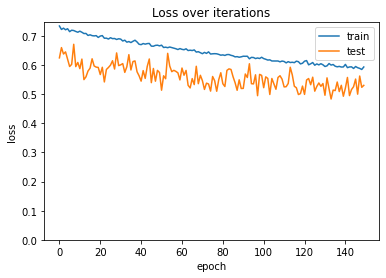

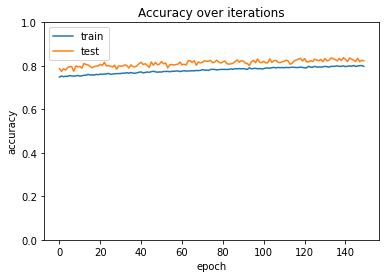

In [24]:
from pandas import read_csv
import matplotlib.pyplot as plt

score = model.evaluate(X_test, Y_test, verbose=0)
print("Loss: " + str(score[0]))
print("Accuracy: " + str(score[1]))
print()

plt.figure()
plt.title('Loss over iterations')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(list(range(len(history.history['loss']))), history.history['loss'])
plt.plot(list(range(len(history.history['val_loss']))), history.history['val_loss'])
plt.ylim(bottom=0)
plt.legend(['train', 'test'], loc='upper right')

plt.figure()
plt.title('Accuracy over iterations')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(bottom=0, top=1)
plt.plot(list(range(len(history.history['accuracy']))), history.history['accuracy'])
plt.plot(list(range(len(history.history['val_accuracy']))), history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper left')